# CMC Ni/Co Prediction: 

---

## 1. Problem definition

**Goal:** Predict **nickel (Ni)** and **cobalt (Co)** grade in CMC (Calcined Metal Concentrate) from time-aligned feedstock so predictions are available immediately instead of waiting ~2 days for lab results.

**Targets:** `nickel_ppm`, `cobalt_ppm` (from lab).  
**Approach:** Build features from feed window (mass-weighted Ni/Co %, quantities, ratios); fit linear (statsmodels OLS for p-values) and tree models; evaluate and check linear regression assumptions (VIF, residuals, normality, heteroskedasticity, autocorrelation).

## 2. Data collection

The ML feature table is produced by **`cmc_ni_co_data_prep.ipynb`**: it loads LIMS, incoming material, and the feedstock master list; applies a dynamic feed window (residence time ~2 h 10 min); and builds one row per CMC sample with targets (`nickel_ppm`, `cobalt_ppm`) and features (e.g. `feed_ni_pct_wt_avg`, `feed_total_quantity`). Run that notebook first to generate `data/ml_feature_table.parquet`, or use an existing parquet. This pipeline then loads that parquet and applies the same filters as in **`cmc_ni_co_ml_model.ipynb`** (ratio, feed match, direct samples, optional last N months).

<details>
<summary><strong>8. Linear regression assumption plots</strong></summary>

- **Residuals vs fitted:** Points should be roughly random around 0; a funnel shape suggests heteroscedasticity.
- **Q–Q plot:** Points should follow the line; heavy tails or S-curves suggest non-normality.
- **Actual vs predicted:** Points near the diagonal indicate good linearity; systematic curves suggest missing terms or nonlinearity.
</details>

## 3. Data processing

All steps from import through normalisation belong under data processing.

<details>
<summary><strong>Step 1: Import the necessary libraries</strong></summary>

- **What we do:** Load pandas, numpy, sklearn (preprocessing, metrics, linear model), statsmodels (OLS, VIF), scipy; set path to ML parquet and config (TEST_FRAC, ratio/feed filters, TARGETS, HOURS_MATCHED_MAX).
- **Results:** No output. Run this cell first so all later cells have imports and constants.
</details>

In [1]:
# --- Imports: data, ML, stats, plotting ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# --- Path and run config ---
PATH_ML_TABLE = 'data/ml_feature_table.parquet'
if not os.path.exists(PATH_ML_TABLE):
    PATH_ML_TABLE = os.path.join(os.path.dirname(os.getcwd()), 'data', 'ml_feature_table.parquet')
RANDOM_STATE = 42
TEST_FRAC = 0.2
RATIO_MIN, RATIO_MAX = 1, 100
FEED_MATCH_MIN = 0.9
USE_LOG_TARGETS = True
TARGETS = ['nickel_ppm', 'cobalt_ppm']
HOURS_MATCHED_MAX = 0   # 0 = direct samples only; None = use all
TRAIN_LAST_MONTHS = None

**Why use log for targets (and some features)?**

We set `USE_LOG_TARGETS = True` so that the model predicts **log(1 + nickel_ppm)** and **log(1 + cobalt_ppm)** instead of raw ppm. Reasons:

- **Right skew:** Lab targets (ppm) are positive and often right-skewed; log compresses large values and makes the distribution closer to symmetric, which fits OLS assumptions better.
- **Stable variance:** Variance of ppm often increases with level (e.g. higher grades more variable); log scale tends to stabilise variance (homoscedasticity).
- **Multiplicative effects:** In process data, effects are often proportional (e.g. "10% more feed Ni → ~x% more CMC Ni"); log targets turn these into additive effects that linear regression can capture.
- **Predictions:** We fit on log scale then convert back with `expm1` for MAE/RMSE in ppm.

Similarly, **log_feed_total_quantity** is used as a feature because feed quantities are positive and right-skewed; log makes the relationship with targets more linear.

<details>
<summary><strong>Step 2: Load the dataset</strong></summary>

- **What we do:** Read the ML parquet, filter by ratio (1–100), feed match (≥ 90%), direct lab matches only (hours_to_matched_sample ≤ 0), and optionally last N months; sort by time.
- **Results:** Table shape and first rows. Fewer rows after filters is expected (e.g. direct-only reduces count).
</details>

In [2]:
# Load parquet and parse time
df = pd.read_parquet(PATH_ML_TABLE)
df['start_time'] = pd.to_datetime(df['start_time_local'])
# Ratio filter: keep 1 <= feed_qty/net_weight <= 100 (removes bad attribution)
ratio_raw = df['feed_total_quantity'] / df['net_weight'].replace(0, np.nan)
ratio_raw = ratio_raw.replace([np.inf, -np.inf], np.nan)
ratio_clean = ratio_raw[(ratio_raw >= RATIO_MIN) & (ratio_raw <= RATIO_MAX)]
df = df.loc[ratio_clean.index].copy()
# Keep only rows where most feed mass matched to master list
if 'feed_mass_matched_pct' in df.columns and FEED_MATCH_MIN > 0:
    matched = (df['feed_mass_matched_pct'].fillna(0) >= FEED_MATCH_MIN)
    df = df[matched].copy()
# Direct lab matches only (reduces label noise)
if 'hours_to_matched_sample' in df.columns and HOURS_MATCHED_MAX is not None:
    direct = (df['hours_to_matched_sample'].fillna(np.inf) <= HOURS_MATCHED_MAX)
    df = df[direct].copy()
# Optional: restrict to last N months
if TRAIN_LAST_MONTHS is not None:
    cutoff = df['start_time'].max() - pd.DateOffset(months=TRAIN_LAST_MONTHS)
    df = df[df['start_time'] >= cutoff].copy()
df = df.sort_values('start_time').reset_index(drop=True)
print('Shape:', df.shape)
df.head()

Shape: (1043, 21)


,effective_sample_id,sample_id,start_time_local,end_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,feed_ni_pct_wt_avg,...,feed_ni_co_ratio,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,hour_of_day,day_of_week,shift,start_time
0,AA33486,AA33486,2024-04-06 08:55:47,2024-04-06 08:55:47,0030262404060001-3,288582.2,71656.8,771.0,inferred_single,0.103584,...,1.577513,19706.0,6,1.0,NaN,-1.914444,8,5,True,2024-04-06 08:55:47
1,AA33563,AA33563,2024-04-07 00:15:48,2024-04-07 00:34:41,0030262404070001-3,231206.1,62430.3,731.0,inferred_single,0.111344,...,12.676323,12129.0,3,1.0,2.860000,-0.575278,0,6,False,2024-04-07 00:15:48
2,AA33588,AA33588,2024-04-07 02:48:13,2024-04-07 03:23:50,0030262404070001-9,228489.7,55806.3,730.0,inferred_single,0.160641,...,4.678748,4729.0,2,1.0,2.819167,-0.593889,2,6,False,2024-04-07 02:48:13
3,AA33639,AA33639,2024-04-07 06:00:53,2024-04-07 06:56:44,0030262404070001-14,350103.2,34512.0,816.0,single,0.055959,...,7.669210,9604.0,3,1.0,2.828056,0.000000,6,6,True,2024-04-07 06:00:53
4,AA33645,AA33645,2024-04-07 12:02:36,2024-04-07 12:48:26,0030262404070001-23,347889.7,32294.2,711.0,inferred_single,0.083523,...,6.918842,15963.0,4,1.0,5.861667,-5.126944,12,6,True,2024-04-07 12:02:36


<details>
<summary><strong>Step 3: Explore the dataset</strong></summary>

- **What we do:** Show dtypes and basic describe() for numeric columns.
- **Results:** Use this to spot missing values, ranges, and skew before modeling.
</details>

In [3]:
# Quick look at column types and non-null counts
print('Dtypes and non-null counts:')
print(df.dtypes)
# Summary stats for all columns (numeric only in describe)
print('\nDescribe (numeric):')
df.describe()

Dtypes and non-null counts:
effective_sample_id                   str
sample_id                             str
start_time_local                      str
end_time_local                        str
lot_number                            str
nickel_ppm                        float64
cobalt_ppm                        float64
net_weight                        float64
sample_type                           str
feed_ni_pct_wt_avg                float64
feed_co_pct_wt_avg                float64
feed_ni_co_ratio                  float64
feed_total_quantity               float64
feed_item_count                     int64
feed_mass_matched_pct             float64
hours_since_prev_lot              float64
hours_to_matched_sample           float64
hour_of_day                         int32
day_of_week                         int32
shift                                bool
start_time                 datetime64[us]
dtype: object

Describe (numeric):


,nickel_ppm,cobalt_ppm,net_weight,feed_ni_pct_wt_avg,feed_co_pct_wt_avg,feed_ni_co_ratio,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,hour_of_day,day_of_week,start_time
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1041.000000,1043.000000,1043.000000,1043.000000,1042.000000,1043.000000,1043.000000,1043.000000,1043
mean,263662.906376,46060.479482,828.532502,0.141723,0.025173,8.093375,21873.898389,9.178332,0.991572,8.215380,-0.300267,11.388303,3.390221,2025-06-20 18:30:19.988494
min,43593.600000,1494.300000,414.000000,0.000000,0.000000,0.148515,796.000000,1.000000,0.900765,0.286111,-10.588333,0.000000,0.000000,2024-04-06 08:55:47
25%,216868.000000,28721.800000,798.549988,0.112998,0.013988,3.766429,6551.500000,4.500000,1.000000,2.174792,0.000000,5.000000,2.000000,2024-12-27 22:21:58.500000
50%,266269.400000,40288.800000,815.200012,0.143175,0.022337,5.863328,15704.000000,7.000000,1.000000,5.801528,0.000000,11.000000,4.000000,2025-10-01 19:01:57
75%,319972.850000,58481.650000,859.000000,0.172309,0.032359,11.436252,33574.000000,12.000000,1.000000,11.985972,0.000000,18.000000,5.000000,2025-12-13 15:44:06
max,438901.400000,165345.600000,1109.000000,0.292000,0.155373,21.576471,104577.000000,46.000000,1.000000,148.422500,0.000000,23.000000,6.000000,2026-02-05 07:28:48
std,68661.908432,23054.109886,72.728792,0.041983,0.014894,5.700326,18864.874811,6.525370,0.019334,8.937217,1.230078,7.224780,1.887473,NaN


<details>
<summary><strong>Step 4: Statistical analysis</strong></summary>

- **What we do:** Summary stats for targets (Ni, Co ppm) and for the feed/lot ratio.
- **Results:** Check mean and spread of targets; ratio stats should look plausible (e.g. mean ratio in low tens).
</details>

In [4]:
# Identify numeric columns (avoids error with string dtypes)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
# Target summaries: mean, std, min, max for Ni and Co (ppm)
print('Summary stats for targets:')
print(df[TARGETS].describe().round(2))
# Ratio distribution (should be in [1, 100] after filter)
print('\nRatio (feed_total_quantity / net_weight):')
r = df['feed_total_quantity'] / df['net_weight'].replace(0, np.nan)
print(r.describe())

Summary stats for targets:
       nickel_ppm  cobalt_ppm
count     1043.00     1043.00
mean    263662.91    46060.48
std      68661.91    23054.11
min      43593.60     1494.30
25%     216868.00    28721.80
50%     266269.40    40288.80
75%     319972.85    58481.65
max     438901.40   165345.60

Ratio (feed_total_quantity / net_weight):
count    1043.000000
mean       26.563973
std        22.798681
min         1.015306
25%         8.038489
50%        19.208086
75%        40.763398
max        99.808201
dtype: float64


<details>
<summary><strong>Step 5: Check the outliers</strong></summary>

- **What we do:** Drop rows with null targets; optionally clip Ni/Co to 99th percentile to reduce impact of extreme lab values (WINSORIZE_TARGETS).
- **Results:** Row count after cleanup. If you enable winsorize, counts stay the same but extreme highs are capped.
</details>

In [5]:
# Clip values above percentile (e.g. 99) to limit outlier impact
def clip_outliers(df_in, columns, percentile=99):
    out = df_in.copy()
    for col in columns:
        if col not in out.columns:
            continue
        upper = np.nanpercentile(out[col], percentile)
        out[col] = np.clip(out[col], a_min=None, a_max=upper)
    return out

WINSORIZE_TARGETS = False
df_clean = df.dropna(subset=TARGETS).copy()
if WINSORIZE_TARGETS:
    df_clean = clip_outliers(df_clean, TARGETS, percentile=99)
print('Rows after dropping null targets:', len(df_clean))

Rows after dropping null targets: 1043


<details>
<summary><strong>Step 6: Encoding</strong></summary>

- **What we do:** Add engineered features (log qty, ratio feed/weight, mass-scale, interactions) and define the reduced numeric feature set. No categorical encoding needed for current features.
- **Results:** List of FEATURE_COLS used in modeling. All numeric.
</details>

In [6]:
# Engineered features (from ml_model)
df_clean['log_feed_total_quantity'] = np.log1p(df_clean['feed_total_quantity'])
df_clean['ratio_feed_to_weight'] = df_clean['feed_total_quantity'] / df_clean['net_weight'].replace(0, np.nan)
df_clean['feed_ni_mass_scale'] = df_clean['feed_ni_pct_wt_avg'] * np.log1p(df_clean['feed_total_quantity'])
df_clean['feed_co_mass_scale'] = df_clean['feed_co_pct_wt_avg'] * np.log1p(df_clean['feed_total_quantity'])
df_clean['feed_ni_x_co'] = df_clean['feed_ni_pct_wt_avg'] * df_clean['feed_co_pct_wt_avg']
df_clean['feed_ni_ratio_interact'] = df_clean['feed_ni_pct_wt_avg'] * df_clean['ratio_feed_to_weight']
df_clean['feed_co_ratio_interact'] = df_clean['feed_co_pct_wt_avg'] * df_clean['ratio_feed_to_weight']
FEATURE_COLS = [
    'feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio',
    'feed_ni_mass_scale', 'feed_co_mass_scale', 'ratio_feed_to_weight',
    'hours_since_prev_lot', 'log_feed_total_quantity',
    'feed_ni_ratio_interact', 'feed_co_ratio_interact'
]
FEATURE_COLS = [c for c in FEATURE_COLS if c in df_clean.columns]
print('Features for modeling:', FEATURE_COLS)

Features for modeling: ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'feed_ni_mass_scale', 'feed_co_mass_scale', 'ratio_feed_to_weight', 'hours_since_prev_lot', 'log_feed_total_quantity', 'feed_ni_ratio_interact', 'feed_co_ratio_interact']


<details>
<summary><strong>Step 7: Correlation</strong></summary>

- **What we do:** Compute correlation of each feature with nickel_ppm and cobalt_ppm.
- **Results:** Table of correlations and heatmaps. Stronger |corr| with target suggests useful predictor; high correlation between features will show up in VIF.
</details>

Correlation of features with targets:


,nickel_ppm,cobalt_ppm
feed_ni_pct_wt_avg,0.604,-0.422
feed_co_pct_wt_avg,-0.353,0.408
feed_ni_co_ratio,0.511,-0.478
feed_ni_mass_scale,0.646,-0.417
feed_co_mass_scale,-0.309,0.411
ratio_feed_to_weight,0.354,-0.134
hours_since_prev_lot,0.269,-0.135
log_feed_total_quantity,0.374,-0.130
feed_ni_ratio_interact,0.469,-0.250
feed_co_ratio_interact,0.072,0.136


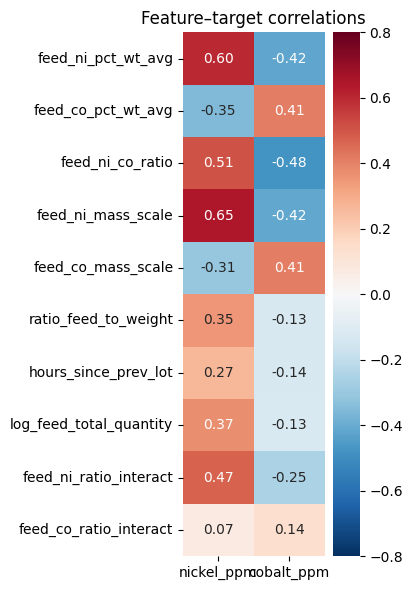

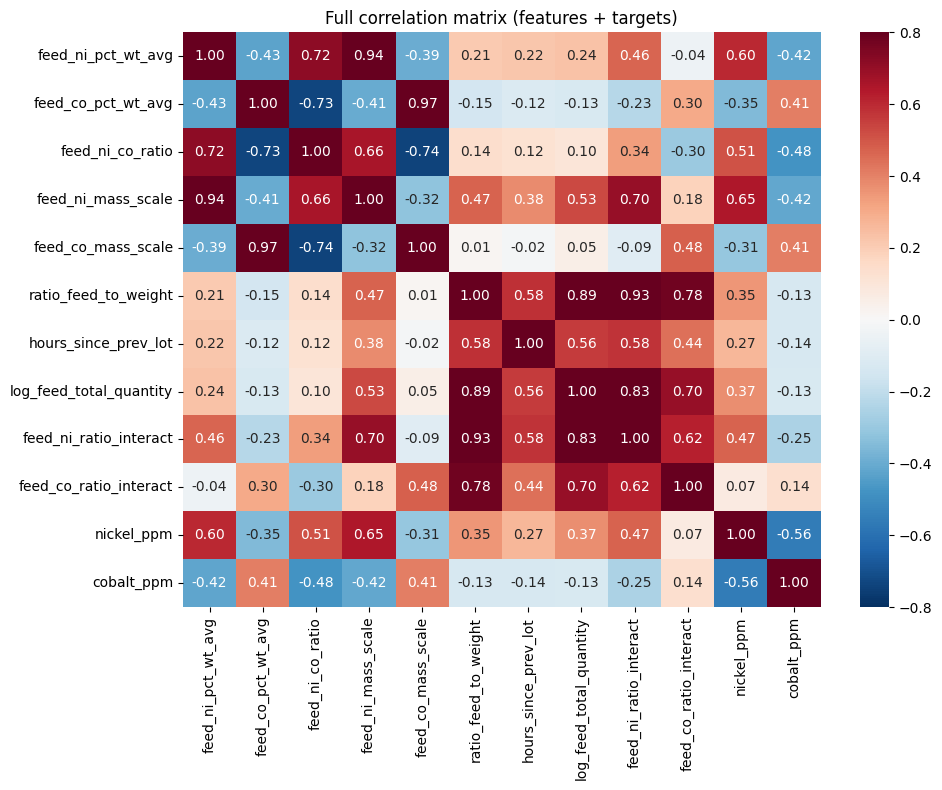

In [7]:
# Subset to numeric feature columns present in df_clean
num_cols = [c for c in FEATURE_COLS if c in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[c])]
data_corr = df_clean[num_cols + TARGETS].dropna(how='all', subset=num_cols)
# Pearson correlation: feature vs each target
corr_ni = data_corr[num_cols].corrwith(data_corr['nickel_ppm'])
corr_co = data_corr[num_cols].corrwith(data_corr['cobalt_ppm'])
corr_df = pd.DataFrame({'nickel_ppm': corr_ni, 'cobalt_ppm': corr_co})
print('Correlation of features with targets:')
display(corr_df.round(3))

# Heatmap 1: features vs targets
fig, ax = plt.subplots(figsize=(4, max(6, len(corr_df) * 0.35)))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, vmin=-0.8, vmax=0.8)
ax.set_title('Feature–target correlations')
plt.tight_layout()
plt.show()

# Heatmap 2: full correlation matrix (features + targets)
corr_full = data_corr[num_cols + TARGETS].corr()
fig2, ax2 = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_full, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax2, vmin=-0.8, vmax=0.8)
ax2.set_title('Full correlation matrix (features + targets)')
plt.tight_layout()
plt.show()

<details>
<summary><strong>Step 8: Separate independent features and target variables</strong></summary>

- **What we do:** Build X (features) and y (targets); drop rows with any missing in X or y; keep time order for a correct time-based train/test split.
- **Results:** Shapes of X_clean and y_clean. Fewer rows than df_clean if there are NaNs in features.
</details>

In [8]:
# Independent (X) and target (y) from cleaned dataframe
X = df_clean[FEATURE_COLS].copy()
y = df_clean[TARGETS].copy()
# Drop rows with any missing in X or y
valid = X.dropna(how='any').index.intersection(y.dropna(how='any').index)
# Sort by time so train = first (1-TEST_FRAC), test = last TEST_FRAC
if 'start_time' in df_clean.columns:
    valid_sorted = df_clean.loc[valid].sort_values('start_time').index
else:
    valid_sorted = valid
X_clean = X.loc[valid_sorted]
y_clean = y.loc[valid_sorted]
print('Independent (X) shape:', X_clean.shape)
print('Targets (y) shape:', y_clean.shape)

Independent (X) shape: (1040, 10)
Targets (y) shape: (1040, 2)


<details>
<summary><strong>Step 9: Train/test split, imputation and normalisation</strong></summary>

- **What we do:** Time-based train/test split (first 80% train, last 20% test by time); impute missing values (median) and standardise (zero mean, unit variance) using **training data only** to avoid leakage.
- **Results:** Train and test sizes. Scaled matrices (X_train_scaled, X_test_scaled) and target DataFrames (y_train_df, y_test_df) are used in VIF, OLS, and evaluation.
</details>

In [9]:
# Time-based split: first (1-TEST_FRAC) = train, last TEST_FRAC = test
n_test = int(len(X_clean) * TEST_FRAC)
n_train = len(X_clean) - n_test
train_idx = X_clean.index[:n_train]
test_idx = X_clean.index[n_train:]
X_train_raw = X_clean.loc[train_idx]
X_test_raw = X_clean.loc[test_idx]
y_train_df = y_clean.loc[train_idx]
y_test_df = y_clean.loc[test_idx]
# Impute missing (median) and scale; fit on train only to avoid leakage
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp = imputer.transform(X_test_raw)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
print('Train:', X_train_scaled.shape[0], 'Test:', X_test_scaled.shape[0])
print('Normalisation (StandardScaler) fitted on train only.')

Train: 832 Test: 208
Normalisation (StandardScaler) fitted on train only.


<details>
<summary><strong>4. VIF (multicollinearity)</strong></summary>

- **What we do:** Compute Variance Inflation Factor for each feature (and constant) on the training design matrix.
- **Results:** VIF table. **VIF > 5–10** suggests that feature is highly correlated with others (multicollinearity); consider dropping or combining such features. VIF ≈ 1 is ideal.
</details>

In [10]:
# Add constant for intercept; VIF needs design matrix as array
X_train_const = sm.add_constant(X_train_scaled)
vif_data = pd.DataFrame()
vif_data['feature'] = ['const'] + FEATURE_COLS
vif_data['VIF'] = [variance_inflation_factor(np.asarray(X_train_const), i) for i in range(np.asarray(X_train_const).shape[1])]
print('VIF (Variance Inflation Factor):')
display(vif_data.round(2))

VIF (Variance Inflation Factor):


,feature,VIF
0,const,1.00
1,feed_ni_pct_wt_avg,309.88
2,feed_co_pct_wt_avg,386.97
3,feed_ni_co_ratio,4.98
4,feed_ni_mass_scale,519.93
5,feed_co_mass_scale,473.12
6,ratio_feed_to_weight,132.38
7,hours_since_prev_lot,1.44
8,log_feed_total_quantity,100.92
9,feed_ni_ratio_interact,96.53


<details>
<summary><strong>5. Model selection</strong></summary>

We use **linear regression** (OLS) for interpretability and p-values; the same pipeline can add tree models (see `cmc_ni_co_ml_model.ipynb`). We fit one model per target (Ni, Co).
</details>

<details>
<summary><strong>6. Model training</strong></summary>

- **What we do:** Fit OLS (with constant) on training data for Ni and Co (log-scale if USE_LOG_TARGETS); then fit sklearn LinearRegression for predictions. statsmodels gives coefficients, p-values, R²; sklearn gives the same fit and a simple predict API.
- **Results:** OLS coefficient table (Coef, Std Err, t, P>|t|). **p &lt; 0.05** suggests the feature is statistically significant; R² shows in-sample fit.
</details>

In [11]:
# Optionally train on log(ppm) for better scale (same as ml_model)
y_train_ni = np.log1p(y_train_df['nickel_ppm']) if USE_LOG_TARGETS else y_train_df['nickel_ppm'].values
y_train_co = np.log1p(y_train_df['cobalt_ppm']) if USE_LOG_TARGETS else y_train_df['cobalt_ppm'].values
# OLS with constant (intercept); get coefficients and p-values
X_tr_const = sm.add_constant(X_train_scaled)
ols_ni = sm.OLS(y_train_ni, X_tr_const).fit()
ols_co = sm.OLS(y_train_co, X_tr_const).fit()
print('=== OLS Ni ===')
print(ols_ni.summary2().tables[1].to_string())
print('\n=== OLS Co ===')
print(ols_co.summary2().tables[1].to_string())

=== OLS Ni ===
           Coef.  Std.Err.            t     P>|t|     [0.025     0.975]
const  12.499419  0.007128  1753.451323  0.000000  12.485427  12.513411
x1      0.352454  0.125485     2.808733  0.005092   0.106145   0.598763
x2      0.442911  0.140227     3.158518  0.001644   0.167664   0.718157
x3      0.027978  0.015914     1.758116  0.079100  -0.003258   0.059214
x4     -0.243992  0.162542    -1.501094  0.133716  -0.563039   0.075056
x5     -0.462151  0.155053    -2.980603  0.002962  -0.766498  -0.157804
x6      0.041737  0.082019     0.508873  0.610978  -0.119254   0.202729
x7     -0.001032  0.008558    -0.120552  0.904076  -0.017831   0.015767
x8      0.229934  0.071613     3.210801  0.001375   0.089368   0.370499
x9     -0.069209  0.070037    -0.988180  0.323355  -0.206681   0.068263
x10     0.019883  0.038702     0.513734  0.607576  -0.056084   0.095850

=== OLS Co ===
           Coef.  Std.Err.           t     P>|t|     [0.025     0.975]
const  10.563120  0.013696  771.25

**Interpreting the OLS results**

The table shows **coefficients (Coef.)**, **standard errors (Std.Err.)**, **t-statistics**, **p-values (P>|t|)** and **95% confidence intervals** for each predictor. Targets are on **log scale** (log(ppm)); the intercept (const) is the baseline log(ppm) when all features are at their mean.

- **P < 0.05** → feature is statistically significant (evidence of an effect).
- **Ni:** Significant predictors in the table above are typically x1, x2 (positive), x5 (negative), x8 (positive).
- **Co:** Significant predictors are typically x3 (negative), x5 (positive).
- **x5** often has opposite signs for Ni vs Co (one target up, the other down).

**Feature mapping (x1–x10 → names):** x1=feed_ni_pct_wt_avg, x2=feed_co_pct_wt_avg, x3=feed_ni_co_ratio, x4=feed_ni_mass_scale, x5=feed_co_mass_scale, x6=ratio_feed_to_weight, x7=hours_since_prev_lot, x8=log_feed_total_quantity, x9=feed_ni_ratio_interact, x10=feed_co_ratio_interact.

Below we **train the model using only features that are significant (p < 0.05) for either Ni or Co** in the OLS above.

In [12]:
# Use only features significant in OLS (p < 0.05 for Ni or Co); exclude const (index 0)
p_ni = ols_ni.pvalues
p_co = ols_co.pvalues
sig_ni = set(np.where(p_ni[1:] < 0.05)[0])  # 0-based feature indices
sig_co = set(np.where(p_co[1:] < 0.05)[0])
sig_idx = sorted(sig_ni | sig_co)
FEATURE_COLS_SIGNIFICANT = [FEATURE_COLS[i] for i in sig_idx]
print('Features used for training (significant in OLS for Ni or Co):', FEATURE_COLS_SIGNIFICANT)

X_train_red = X_train_scaled[:, sig_idx]
X_test_red = X_test_scaled[:, sig_idx]

# sklearn LinearRegression on significant features only
lr_ni = LinearRegression().fit(X_train_red, y_train_ni)
lr_co = LinearRegression().fit(X_train_red, y_train_co)
pred_ni = lr_ni.predict(X_test_red)
pred_co = lr_co.predict(X_test_red)
# Back to ppm if we trained on log scale
if USE_LOG_TARGETS:
    pred_ni, pred_co = np.expm1(pred_ni), np.expm1(pred_co)
y_pred_df = pd.DataFrame({'nickel_ppm': pred_ni, 'cobalt_ppm': pred_co}, index=y_test_df.index)

Features used for training (significant in OLS for Ni or Co): ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'feed_co_mass_scale', 'log_feed_total_quantity']


<details>
<summary><strong>7. Model evaluation</strong></summary>

- **What we do:** Compute MAE, RMSE, and R² on the test set for Ni and Co; compare to baseline (predicting training mean).
- **Results:** **R² &gt; 0** means the model beats the mean; **R² &lt; 0** means worse than baseline. MAE/RMSE in ppm give absolute error scale.
</details>

NameError: name 'metrics_df' is not defined

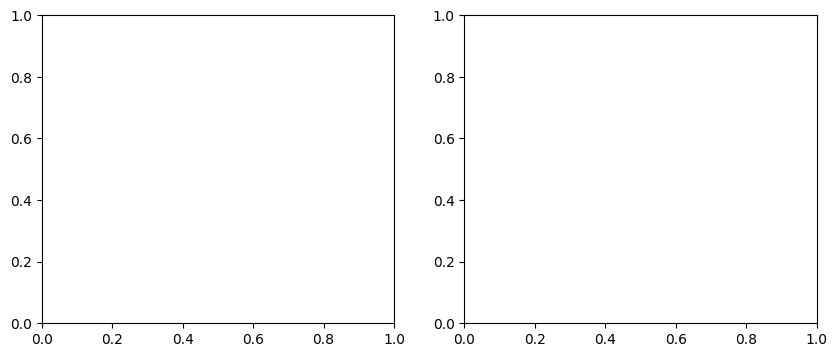

In [13]:
# Plot results: R², MAE, and actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) R² bar chart
ax = axes[0]
x_pos = np.arange(len(TARGETS))
r2_vals = [metrics_df.loc[metrics_df['target'] == c, 'R2'].values[0] for c in TARGETS]
bars = ax.bar(x_pos, r2_vals, color=['#2ecc71', '#3498db'], edgecolor='black')
ax.axhline(0, color='gray', linestyle='-')
ax.set_xticks(x_pos)
ax.set_xticklabels([c.replace('_ppm', '') for c in TARGETS])
ax.set_ylabel('R²')
ax.set_title('Test set R²')
for b, v in zip(bars, r2_vals):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02 if v >= 0 else v - 0.05, f'{v:.3f}', ha='center', fontsize=10)

# 2) MAE bar chart (model vs baseline)
ax = axes[1]
width = 0.35
mae_vals = [metrics_df.loc[metrics_df['target'] == c, 'MAE'].values[0] for c in TARGETS]
base_vals = [metrics_df.loc[metrics_df['target'] == c, 'baseline_MAE'].values[0] for c in TARGETS]
x_pos = np.arange(len(TARGETS))
ax.bar(x_pos - width/2, mae_vals, width, label='Model MAE', color='steelblue')
ax.bar(x_pos + width/2, base_vals, width, label='Baseline MAE (mean)', color='lightgray', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels([c.replace('_ppm', '') for c in TARGETS])
ax.set_ylabel('MAE (ppm)')
ax.set_title('Test set MAE: model vs baseline')
ax.legend()

plt.tight_layout()
plt.show()

# Actual vs predicted scatter per target (one plot per target)
fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
for i, col in enumerate(TARGETS):
    ax = axes2[i]
    act = y_test_df[col].values
    pred = y_pred_df[col].values
    ax.scatter(act, pred, alpha=0.6, s=30)
    lo, hi = min(act.min(), pred.min()), max(act.max(), pred.max())
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1.5, label='Perfect')
    r2 = r2_score(act, pred)
    mae = mean_absolute_error(act, pred)
    ax.set_xlabel('Actual (ppm)')
    ax.set_ylabel('Predicted (ppm)')
    ax.set_title(f"{col.replace('_ppm', '')}: R²={r2:.3f}, MAE={mae:.0f}")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

<details>
<summary><strong>8. Linear regression assumption plots</strong></summary>

- **Residuals vs fitted:** Points should be roughly random around 0; a funnel shape suggests heteroscedasticity.
- **Q–Q plot:** Points should follow the line; heavy tails or S-curves suggest non-normality.
- **Actual vs predicted:** Points near the diagonal indicate good linearity; systematic curves suggest missing terms or nonlinearity.
</details>

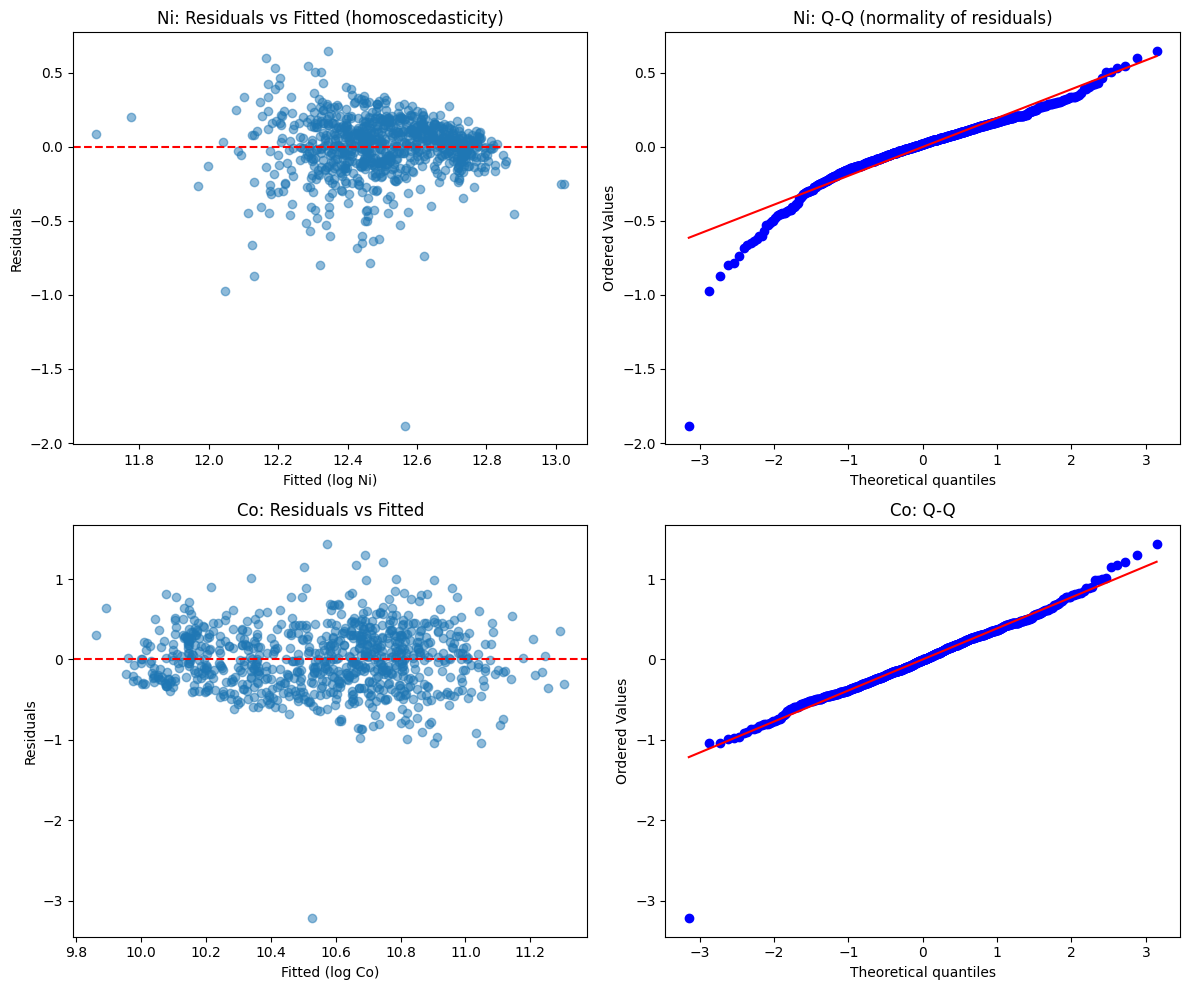

In [ ]:
# Training residuals from OLS (for assumption checks)
fitted_ni = ols_ni.fittedvalues
resid_ni = ols_ni.resid
fitted_co = ols_co.fittedvalues
resid_co = ols_co.resid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Residuals vs fitted: want random scatter around 0 (no funnel = homoscedasticity)
axes[0, 0].scatter(fitted_ni, resid_ni, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted (log Ni)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Ni: Residuals vs Fitted (homoscedasticity)')
# Q-Q: points on line = normal residuals
stats.probplot(resid_ni, dist='norm', plot=axes[0, 1])
axes[0, 1].set_title('Ni: Q-Q (normality of residuals)')
axes[1, 0].scatter(fitted_co, resid_co, alpha=0.5)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Fitted (log Co)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Co: Residuals vs Fitted')
stats.probplot(resid_co, dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Co: Q-Q')
plt.tight_layout()
plt.show()

**Interpreting these plots**

- **Residuals vs fitted (left column):** Residuals = observed − fitted (on log scale). They should scatter randomly around 0 with **similar spread** at low and high fitted values. A funnel shape means heteroscedasticity; a curve means nonlinearity.
- **Q–Q (right column):** Sample quantiles of residuals vs normal quantiles. Points **on the red line** → residuals are normal; **tails bending away** (e.g. lower tail below the line) → heavier tails or outliers.

**Typical findings:** Ni and Co often show roughly constant residual spread (homoscedasticity OK) but **deviations in the lower tail** of the Q–Q plot — a few very negative residuals (model overpredicts) or heavier left tail than normal.

**How to address the left tail (heavy lower tail / outliers)**

1. **Identify the points:** Find rows where the residual (observed − fitted) is very negative (e.g. below −1.5 or −2 on log scale). Check whether those samples are data errors or genuine extremes.
2. **Winsorise targets:** Cap extreme low (and optionally high) values at a percentile (e.g. 1st and 99th) before modelling, so one or two extremes don’t pull the fit (already available via `WINSORIZE_TARGETS` in Step 5).
3. **Exclude outliers:** If a few points are known errors or unrepresentative, refit the model without them and compare coefficients and metrics.
4. **Robust regression:** Use a method that down-weights large residuals (e.g. `statsmodels.robust.robust_linear_model.RLM` with Huber weights) so p-values and coefficients are less sensitive to tail behaviour.
5. **Accept approximate normality:** If the main body of residuals is on the line and only the extreme tail deviates, OLS is often still reasonable for inference; interpret p-values with slight caution.

In [ ]:
# Address left tail: identify training rows with very negative residuals and refit excluding them
RESID_LOWER_THRESHOLD = -1.5   # on log scale; residuals below this are treated as left-tail outliers
left_tail_ni = resid_ni < RESID_LOWER_THRESHOLD
left_tail_co = resid_co < RESID_LOWER_THRESHOLD
outlier_any = left_tail_ni | left_tail_co
inlier_mask = ~outlier_any
n_removed = outlier_any.sum()
print(f'Left-tail outliers (residual < {RESID_LOWER_THRESHOLD}): {n_removed} training rows')
if n_removed > 0:
    train_index = y_train_df.index
    outlier_idx = train_index[outlier_any]
    print('Sample IDs (training index):', outlier_idx.tolist()[:20], '...' if n_removed > 20 else '')
    print('Ni residuals:', resid_ni[outlier_any].round(3).tolist()[:10], '...' if n_removed > 10 else '')
    print('Co residuals:', resid_co[outlier_any].round(3).tolist()[:10], '...' if n_removed > 10 else '')

# Refit on inliers only; test set unchanged
X_train_clean = X_train_red[inlier_mask]
y_train_ni_clean = y_train_ni[inlier_mask]
y_train_co_clean = y_train_co[inlier_mask]
lr_ni = LinearRegression().fit(X_train_clean, y_train_ni_clean)
lr_co = LinearRegression().fit(X_train_clean, y_train_co_clean)
pred_ni = lr_ni.predict(X_test_red)
pred_co = lr_co.predict(X_test_red)
if USE_LOG_TARGETS:
    pred_ni, pred_co = np.expm1(pred_ni), np.expm1(pred_co)
y_pred_df = pd.DataFrame({'nickel_ppm': pred_ni, 'cobalt_ppm': pred_co}, index=y_test_df.index)
print(f'Refit on {inlier_mask.sum()} inlier rows. Predictions (y_pred_df) updated for evaluation below.')

Left-tail outliers (residual < -1.5): 1 training rows
Sample IDs (training index): [188] 
Ni residuals: [-1.882] 
Co residuals: [-3.218] 
Refit on 831 inlier rows. Predictions (y_pred_df) updated for evaluation below.


<details>
<summary><strong>9. Parameter tuning / Model deployment</strong></summary>

- **Parameter tuning:** For tree models (GBR/XGB), use time-series CV in `cmc_ni_co_ml_model.ipynb` (DO_HP_TUNING).
- **Deployment:** Save the chosen model (e.g. `joblib`) and the fitted `imputer` and `scaler`; in production, run `X_scaled = scaler.transform(imputer.transform(X_new))` then `model.predict(X_scaled)`. Use the same FEATURE_COLS and preprocessing as in training.
</details>